# Questions

**Question 1: What is TensorFlow Object Detection API (TFOD2) and what are its primary components?**
  - TensorFlow Object Detection API is an open-source framework by Google built on TensorFlow 2 that allows us to build, train and evaluate object detection models.
  - It is widely used for detecting and localizing multiple objects in images by drawing bounding boxes and assigning class labels with confidence scores.
  - Primary Components of TFOD2:-
    - It contains ready to use object detection models trained on large datasets like COCO.
    - It is used to customize training parameters such as learning rate, number of classes, batch size and model type.
    - It have scripts to train models, evaluate performance and monitor metrics like precision and recall.

**Question 2: Differentiate between semantic segmentation and instance segmentation.Provide examples of where each might be used.**
  - Semantic Segmentation:-
    - It assigns a class label to every pixel in an image.
    - It does not distinguish between different objects of the same class.
    - All objects belonging to the same category are treated as one region.
    - It focuses on what the object is and not how many there are.
    - Example :- Road and lane detection in autonomous driving.
  - Instance segmentation:-
    - It assigns a class label and a unique ID to every object in the image.
    - It separates individual objects even if they belong to the same class.
    - It provides both object detection and pixel-level segmentation.
    - It focuses on what the object is and which instance it is.
    - Example :- Detecting and counting people in crowd analysis. 0r Object tracking in video surveillance.

**Question 3: Explain the Mask R-CNN architecture. How does it extend Faster R-CNN?**
  - Mask R-CNN is a deep learning model used for instance segmentation.
  - It detects objects in an image and also generates a pixel-level mask for each detected object.
  - Mask R-CNN builds upon the Faster R-CNN architecture by adding a segmentation capability.
  - It uses CNNs like ResNet with Feature Pyramid Network.
  - It proposes bounding boxes likely to contain objects.
  - Then precisely aligns extracted features with the input image.
  - Replaces RoI Pooling to avoid misalignment caused by quantization.
  - Then performs classification and bounding box regression to identify object class and refines bounding box coordinates.
  - Generates a binary segmentation mask for each RoI.
  - Faster R-CNN performs object detection only whereas Mask R-CNN adds an additional mask prediction branch in parallel.
  - It introduces RoI Align for more accurate spatial alignment.

**Question 4: Describe the purpose of masks in image segmentation. How are they used during training and inference?**
  - In image segmentation a mask is used to indicate which pixels belong to which class or object.
  - A mask provides pixel level labels for an image.
  - Instead of assigning one label to the whole image or a box a mask tells the model exactly where an object is.
  - Each pixel in the mask corresponds to a pixel in the image.
  - The model takes an input image.
  - Then it predicts a segmentation map or mask.
  - This predicted mask is then compared to the ground truth mask.
  - A loss function measures pixel-by-pixel differences.
  - And the model updates its weights to reduce this difference.

**Question 5: What are the steps involved in training a custom image segmentation model using TFOD2?**
  - Steps involved in training a custom image segmentation model using TFOD2:-
    - Set up the environment:-
      - Install TensorFlow 2.x.
      - Clone the TensorFlow Object Detection API.
      - Install required dependencies and compile protobufs.
    - Prepare the dataset:-
      - Collect images relevant to your segmentation task.
      - Create segmentation annotations or masks.
      - Split the dataset in train and validation.
    - Convert data to TFRecord format:-
      - Convert images and corresponding masks into TFRecord files.
      - TFOD2 uses TFRecords for efficient data loading.
    - Create labeled map:-
      - Define all segmentation classes in a `.pbtxt` file.
      - Assign a unique ID and name to each class.
      - Download a pre-trained checkpoint for transfer learning.
    - Train the model:-
      - Start training using the TFOD2 training script.
      - Monitor values like Loss values, Mask loss and Classification loss.
    - Evaluate the model:-
      - Run evaluation on the validation set.
      - Use measure metrics such as `mAP` and `Mask IoU`.

In [1]:
# Question 6: Write a Python script to install TFOD2 and verify its installation by printing the available model configs.

#!pip install -U pip
#!pip install tensorflow
#!pip install pillow lxml Cython contextlib2 matplotlib pandas opencv-python
#!pip install tf_slim pycocotools protobuf

!git clone --depth 1 https://github.com/tensorflow/models.git

%cd models/research
!protoc object_detection/protos/*.proto --python_out=.

!pip install .

import sys
try:
    from object_detection.utils import label_map_util
    from object_detection.utils import config_util
    print("TFOD2 successfully imported")
except Exception as e:
    print("TFOD2 import failed:", e)

import pathlib
config_dir = pathlib.Path('object_detection/configs/tf2')
print("Available TF2 model configs:\n")
for cfg in sorted(config_dir.glob("*.config")):
    print(" -", cfg.name)


Cloning into 'models'...
remote: Enumerating objects: 4411, done.
remote: Counting objects: 100% (4411/4411), done.
remote: Compressing objects: 100% (3227/3227), done.
remote: Total 4411 (delta 1191), reused 3111 (delta 1109), pack-reused 0 (from 0)
Receiving objects: 100% (4411/4411), 70.07 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (1191/1191), done.
Updating files: 100% (3972/3972), done.
/content/models/research
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
TFOD2 import failed: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.googl

Extracting images.tar.gz ...


/tmp/ipython-input-3533317175.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=BASE_DIR)


Done extracting images.tar.gz
Extracting annotations.tar.gz ...
Done extracting annotations.tar.gz


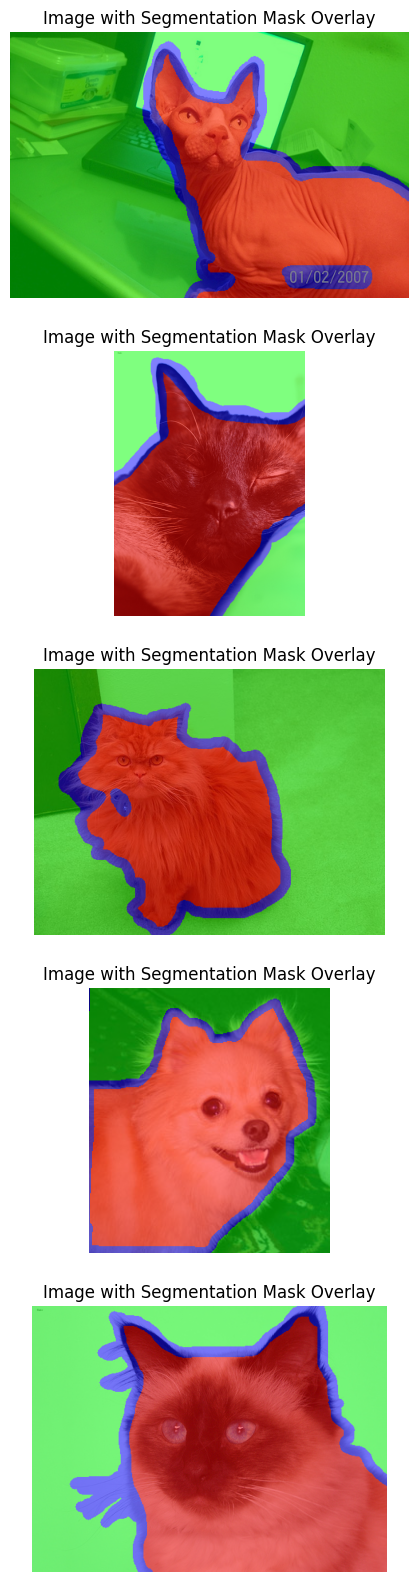

In [5]:
# Question 7: Create a Python script to load a labeled dataset (in TFRecord format) and visualize the annotation masks over the images.
import os
import urllib.request
import tarfile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np
import random

BASE_DIR = "oxford_pets"
IMAGES_DIR = os.path.join(BASE_DIR, "images")
MASKS_DIR = os.path.join(BASE_DIR, "annotations", "trimaps")
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)

images_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
annotations_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

def download_and_extract(url, extract_to):
    filename = url.split("/")[-1]
    filepath = os.path.join(BASE_DIR, filename)

    if not os.path.exists(filepath):
        print(f"Downloading {filename} ...")
        urllib.request.urlretrieve(url, filepath)
    else:
        print(f"{filename} already exists")

    print(f"Extracting {filename} ...")
    with tarfile.open(filepath, "r:gz") as tar:
        tar.extractall(path=BASE_DIR)
    print(f"Done extracting {filename}")

download_and_extract(images_url, IMAGES_DIR)
download_and_extract(annotations_url, MASKS_DIR)

def load_image_mask_pairs(num_samples=5):
    all_images = [f for f in os.listdir(IMAGES_DIR) if f.endswith(".jpg")]
    selected_images = random.sample(all_images, num_samples)

    image_mask_pairs = []
    for img_name in selected_images:
        img_path = os.path.join(IMAGES_DIR, img_name)
        mask_name = img_name.replace(".jpg", ".png")
        mask_path = os.path.join(MASKS_DIR, mask_name)

        if not os.path.exists(mask_path):
            continue

        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))
        image_mask_pairs.append((img, mask))

    return image_mask_pairs

pairs = load_image_mask_pairs(num_samples=5)

def visualize_pairs(pairs):
    plt.figure(figsize=(10, len(pairs)*4))

    colors = {
        1: [1, 0, 0],
        2: [0, 1, 0],
        3: [0, 0, 1],
    }

    for i, (img, mask) in enumerate(pairs):
        colored_mask = np.zeros_like(img, dtype=np.float32)
        for class_id, color in colors.items():
            colored_mask[mask == class_id] = color

        overlay = 0.5 * img/255.0 + 0.5 * colored_mask

        plt.subplot(len(pairs), 1, i+1)
        plt.imshow(overlay)
        plt.axis("off")
        plt.title("Image with Segmentation Mask Overlay")

    plt.show()

visualize_pairs(pairs)



In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tarfile

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

MODEL_NAME = 'mask_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8'
MODEL_FILE = f'{MODEL_NAME}.tar.gz'
MODEL_URL = f'http://download.tensorflow.org/models/object_detection/tf2/20200711/{MODEL_FILE}'

print(f"Downloading {MODEL_NAME}...")
if not os.path.exists(MODEL_NAME):
    ret_code = os.system(f'wget -q -O {MODEL_FILE} {MODEL_URL}')

    if ret_code != 0:
        print("!! Download failed. Trying alternative mirror...")
        os.system(f'curl -L -o {MODEL_FILE} {MODEL_URL}')

    print("Extracting...")
    tar = tarfile.open(MODEL_FILE)
    tar.extractall()
    tar.close()
else:
    print("Model already downloaded.")

print("Loading SavedModel (this may take 1-2 minutes)...")
tf.keras.backend.clear_session()
model_path = os.path.join(MODEL_NAME, 'saved_model')
detect_fn = tf.saved_model.load(model_path)

PATH_TO_LABELS = os.path.join('models', 'research', 'object_detection', 'data', 'mscoco_label_map.pbtxt')

if not os.path.exists(PATH_TO_LABELS):
    PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

IMAGE_NAME = 'test_image.jpg'
IMAGE_URL = 'https://upload.wikimedia.org/wikipedia/commons/8/8d/President_Barack_Obama.jpg'

if not os.path.exists(IMAGE_NAME):
    os.system(f'wget -q -O {IMAGE_NAME} {IMAGE_URL}')

image_np = load_image_into_numpy_array(IMAGE_NAME)

print("Running inference...")
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

print("Processing masks...")
if 'detection_masks' in detections:
    detection_masks_reframed = viz_utils.reframe_box_masks_to_image_masks(
        detections['detection_masks'], detections['detection_boxes'],
        image_np.shape[0], image_np.shape[1])
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
    detections['detection_masks_reframed'] = detection_masks_reframed.numpy()

print("Plotting...")
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'],
    detections['detection_scores'],
    category_index,
    instance_masks=detections.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8,
    min_score_thresh=0.5
)

plt.figure(figsize=(12, 16))
plt.imshow(image_np_with_detections)
plt.axis('off')
plt.show()

!! Download failed. Trying alternative mirror...
Extracting...


ReadError: file could not be opened successfully:
- method gz: ReadError('not a gzip file')
- method bz2: ReadError('not a bzip2 file')
- method xz: ReadError('not an lzma file')
- method tar: ReadError('truncated header')

In [16]:
# Question 9: Write a Python script to evaluate a trained TFOD2 Mask R-CNN model and plot the Precision-Recall curve.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from object_detection.utils import dataset_util, label_map_util, object_detection_evaluation
from object_detection.utils import visualization_utils as viz_utils

SAVED_MODEL_PATH = "path/to/your_trained_mask_rcnn/saved_model"
TEST_TFRECORD = "path/to/test_dataset.tfrecord"
LABEL_MAP_PATH = "path/to/label_map.pbtxt"

NUM_CLASSES = 90

detect_fn = tf.saved_model.load(SAVED_MODEL_PATH)
print("Model loaded!")

category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH)

raw_dataset = tf.data.TFRecordDataset(TEST_TFRECORD)

def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.cast(image, tf.float32)

    xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'])
    boxes = tf.stack([ymin, xmin, ymax, xmax], axis=1)
    classes = tf.sparse.to_dense(example['image/object/class/label'])

    return image, boxes, classes

dataset = raw_dataset.map(parse_tfrecord_fn)

evaluator = object_detection_evaluation.ObjectDetectionEvaluator(num_classes=NUM_CLASSES)

for image, gt_boxes, gt_classes in dataset:
    input_tensor = tf.expand_dims(image, axis=0)
    detections = detect_fn(input_tensor)

    pred_boxes = detections['detection_boxes'][0].numpy()
    pred_scores = detections['detection_scores'][0].numpy()
    pred_classes = detections['detection_classes'][0].numpy().astype(np.int32)

    threshold = 0.5
    valid = pred_scores >= threshold
    pred_boxes = pred_boxes[valid]
    pred_scores = pred_scores[valid]
    pred_classes = pred_classes[valid]

    evaluator.add_single_ground_truth_image_info(
        image_id=id(image),
        groundtruth_dict={
            'groundtruth_boxes': gt_boxes.numpy(),
            'groundtruth_classes': gt_classes.numpy()
        }
    )
    evaluator.add_single_detected_image_info(
        image_id=id(image),
        detections_dict={
            'detection_boxes': pred_boxes,
            'detection_scores': pred_scores,
            'detection_classes': pred_classes
        }
    )

metrics = evaluator.evaluate()
precision = metrics['Precision/mAP@0.50IOU']
print("mAP@0.5:", precision)



TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

**Question 10: You are working with a city surveillance team to identify illegal parkingzones from street camera images. The model you built detects cars using boundingboxes, but the team reports inaccurate overlaps with sidewalks and fails in complexstreet scenes.**
**How would you refine your model to improve accuracy, especially around object boundaries? What segmentation strategy and tools would you use?**
  - Problem with current approach:-
    - Current model uses object detection with bounding boxes, which often results in overlaps with sidewalks and poor detection in crowded or complex street scenes.
    - And bounding boxes do not capture the exact shape or boundaries of cars.
  - Switch from Detection to Segmentation:-
    -  We can use instance segmentation instead of just object detection.
    - Which will provide pixel-level masks for each car, reduces false overlaps with sidewalks and improves detection in complex or occluded scenarios.
  - We can use models like:-
    - Mask R-CNN:-
      - It combines bounding box detection with pixel-wise masks.
      - And is widely used for vehicle segmentation in street scenes.
    - YOLOv8 Segmentation:-
      - It perform real time instance segmentation with good accuracy.
  - Annotation Strategy:-
    - We should use high-quality labeled masks instead of just bounding boxes.
    - Consider data augmentation like rotation, lighting and occlusion simulation.
  - Boundary Refinement Techniques:-
    - Apply Conditional Random Fields or edge aware loss functions to improve mask edges.
    - We should use multi-scale feature extraction to capture both large cars and small details like wheel boundaries.
  - Post-Processing:-
    - Filter out masks overlapping with sidewalk regions using road segmentation maps.
    - Combine segmentation output with geospatial rules to flag only illegal parking zones.